#### Imports

In [1]:
import os
from PIL import Image
import pandas as pd
import torch
from torch import optim
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split


C:\Python\Lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### Dataset class

In [17]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, img_folder, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_folder = img_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_folder, f"{self.df['unique_id'].iloc[idx]}.jpg")
        image = Image.open(img_name)  # stack overflow .convert("RGB")

        target = torch.tensor(self.df['loss_percentage'].iloc[idx], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, target

In [18]:
df = 'filtered_data.csv'
img_folder_path = 'SolarPanelSoilingImageDataset\Solar_Panel_Soiling_Image_dataset\Pytorch_data/'

In [19]:
transform = transforms.Compose([
    transforms.Resize((192, 192)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [20]:
custom_dataset = CustomDataset(csv_file='filtered_data.csv', img_folder=img_folder_path, transform=transform)


In [21]:
dataloader = DataLoader(custom_dataset, batch_size=32, shuffle=False)


### Visualize the loaded data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

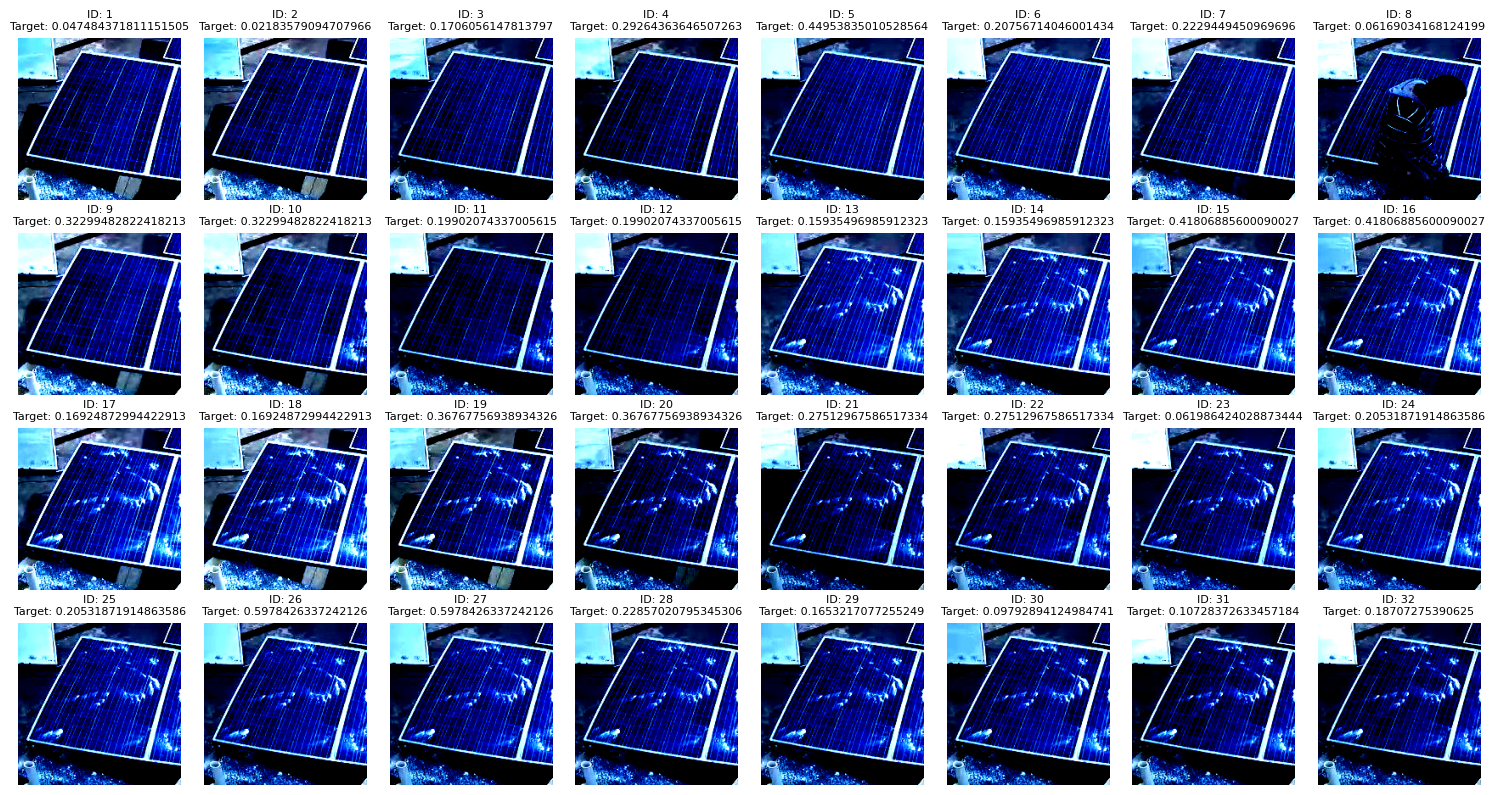

In [22]:
images, targets = next(iter(dataloader))

# Convert images to numpy arrays
np_images = images.numpy()

# Define the size of the grid
num_rows = 4
num_cols = 8

# Set the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Visualize each image along with its target and ID from the folder
for i in range(num_rows * num_cols):
    image = np.transpose(np_images[i], (1, 2, 0))  # Change the order of dimensions for displaying with matplotlib
    target = targets[i].item()
    image_id = custom_dataset.df['unique_id'].iloc[i]

    axes[i].imshow(image)
    axes[i].set_title(f'ID: {image_id}\nTarget: {target}', fontsize=8)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### NN Architecture

In [23]:
class RegressionCNN(nn.Module):
    def __init__(self):
        super(RegressionCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 48 * 48, 512)
        self.fc2 = nn.Linear(512, 1)  # Output dimension is 1 for regression

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the input for the fully connected layers
        x = x.view(-1, 128 * 48 * 48)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [28]:
def train_regression(model, train_loader, learning_rate=0.001, epochs=10):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.to(device)

    # Lists to store MSE values for visualization
    mse_values = []


    for epoch in range(epochs):
        model.train()  # Set the model to training mode

        total_loss = 0.0

        for inputs, target in train_loader:
            inputs, target = inputs.to(device), target.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            # Modify this line to reshape the target tensor
            target = target.view(-1, 1, 1, 1).float()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Print average loss for the epoch
        average_loss = total_loss / len(train_loader)
        mse_values.append(average_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {average_loss:.4f}")

    print("Training finished.")

    # Plot MSE values
    plt.plot(range(1, epochs + 1), mse_values, marker='o', linestyle='-')
    plt.title('Mean Squared Error (MSE) per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.show()

#### Train Test Split

In [25]:
train_dataset, test_dataset = train_test_split(custom_dataset, test_size=0.2)

# Create DataLoader instances for training and testing sets
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [26]:
model = RegressionCNN()


In [29]:
train_regression(model, train_dataloader, learning_rate=0.001, epochs=10)

C:\Python\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32, 1, 1, 1])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 